## TODO

- Make sure that when splitting dataset it accounts for batching or not

- Reduce shuffle and see reason for performance problems

- Baysian hyper paramater optimization

- Find way tensorflow is under utilizing gpu with tensorflow
    - Use tensorbaord
    
- Create seperate validation and train file sets

# Imports

Import the required libraries.

In [1]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors

import tensorflow as tf
import collections
import datetime
import timeit
import os
import random
from keras import backend as K

#### For testing purposes
random.seed(1)
###

In [55]:
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'

# Load the dataset

Enter the Unix glob file pattern of the data files.

Here we load the training data. All the data are stored in TensorFlow Record files.
Replace 'train' with 'eval' or 'test' to load the evaluation or testing data, respectively.

Run the following three cells to define the required library functions for loading the data.

The first cell defines the name of the variables in the input files and the corrresponding data statistics. The statistics can be used for preprocessing the data. 

In [2]:
"""Constants for the data reader."""

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']


OUTPUT_FEATURES = ['detectionImage']

# Data statistics 
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, standard deviation)
DATA_STATS = {
    # Elevation in m.
    # 0.1 percentile, 99.9 percentile
    'elevation': (0.0, 3141.0, 657.3003, 649.0147),
    
    # Drought Index (Palmer Drought Severity Index)
    # 0.1 percentile, 99.9 percentile
    'pdsi': (-6.12974870967865, 7.876040384292651, -0.0052714925, 2.6823447),
    
    #Vegetation index (times 10,000 maybe, since it's supposed to be b/w -1 and 1?)
    'NDVI': (-9821.0, 9996.0, 5157.625, 2466.6677),  # min, max
   
    # Precipitation in mm.
    # Negative values do not make sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 44.53038024902344, 1.7398051, 4.482833),
   
    # Specific humidity.
    # Negative values do not make sense, so min is set to 0.
    # The range of specific humidity is up to 100% so max is 1.
    'sph': (0., 1., 0.0071658953, 0.0042835088),
    
    # Wind direction in degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th': (0., 360.0, 190.32976, 72.59854),
    
    # Min/max temperature in Kelvin.
    
    #Min temp
    # -20 degree C, 99.9 percentile
    'tmmn': (253.15, 298.94891357421875, 281.08768, 8.982386),
    
    #Max temp
    # -20 degree C, 99.9 percentile
    'tmmx': (253.15, 315.09228515625, 295.17383, 9.815496),
    
    # Wind speed in m/s.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs': (0.0, 10.024310074806237, 3.8500874, 1.4109988),
    
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc': (0.0, 106.24891662597656, 37.326267, 20.846027),
    
    # Population density
    # min, 99.9 percentile
    'population': (0., 2534.06298828125, 25.531384, 154.72331),
    
    # We don't want to normalize the FireMasks.
    # 1 indicates fire, 0 no fire, -1 unlabeled data
    'PrevFireMask': (0., 1., 0., 1.),
    'detectionImage': (0, 1., 0., 1.)
}

The following cell defines cropping functions for extracting regions of the desired size from the input data.

In [3]:
"""Library of common functions used in deep learning neural networks.
"""
#YOU PROBABLY WILL NOT USE THESE.

def random_crop_input_and_output_images(
        input_img: tf.Tensor,
        output_img: tf.Tensor,
        sample_size: int,
        num_in_channels: int,
        num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Randomly axis-align crop input and output image tensors.

    Args:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
        sample_size: side length (square) to crop to.
        num_in_channels: number of channels in input_img.
        num_out_channels: number of channels in output_img.
    Returns:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
    """
    combined = tf.concat([input_img, output_img], axis=2)
    combined = tf.image.random_crop(
            combined,
            [sample_size, sample_size, num_in_channels + num_out_channels])
    input_img = combined[:, :, 0:num_in_channels]
    output_img = combined[:, :, -num_out_channels:]
    return input_img, output_img


def center_crop_input_and_output_images(
        input_img: tf.Tensor,
        output_img: tf.Tensor,
        sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Center crops input and output image tensors.

    Args:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
        sample_size: side length (square) to crop to.
    Returns:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
    """
    central_fraction = sample_size / input_img.shape[0]
    input_img = tf.image.central_crop(input_img, central_fraction)
    output_img = tf.image.central_crop(output_img, central_fraction)
    return input_img, output_img

The following cell provides code for parsing the contents of the TensorFlow Record files. In addition to loading the data, it also offers functions for various preprocessing operations, such as clipping, rescaling, or normalizing the data.  

In [56]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
    """Extracts the base key from the provided key.

    Earth Engine exports TFRecords containing each data variable with its
    corresponding variable name. In the case of time sequences, the name of the
    data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
    where 'variable' is the name of the variable, and n the number of elements
    in the time sequence. Extracting the base key ensures that each step of the
    time sequence goes through the same normalization steps.
    The base key obeys the following naming pattern: '([a-zA-Z]+)'
    For instance, for an input key 'variable_1', this function returns 'variable'.
    For an input key 'variable', this function simply returns 'variable'.

    Args:
        key: Input key.

    Returns:
        The corresponding base key.

    Raises:
        ValueError when `key` does not match the expected pattern.
    """
    match = re.match(r'([a-zA-Z]+)', key)
    if match:
        return match.group(1)
    raise ValueError(
            'The provided key does not match the expected pattern: {}'.format(key))


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
    """Clips and rescales inputs with the stats corresponding to `key`.

    Args:
        inputs: Inputs to clip and rescale.
        key: Key describing the inputs.

    Returns:
        Clipped and rescaled input.

    Raises:
        ValueError if there are no data statistics available for `key`.
    """
    base_key = _get_base_key(key)
    if base_key not in DATA_STATS:
        raise ValueError(
                'No data statistics available for the requested key: {}.'.format(key))
    min_val, max_val, _, _ = DATA_STATS[base_key]
    inputs = tf.clip_by_value(inputs, min_val, max_val)
    return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
    """Clips and normalizes inputs with the stats corresponding to `key`.

    Args:
        inputs: Inputs to clip and normalize.
        key: Key describing the inputs.

    Returns:
        Clipped and normalized input.

    Raises:
        ValueError if there are no data statistics available for `key`.
    """
    base_key = _get_base_key(key)
    if base_key not in DATA_STATS:
        raise ValueError(
                'No data statistics available for the requested key: {}.'.format(key))
    min_val, max_val, mean, std = DATA_STATS[base_key]
    inputs = tf.clip_by_value(inputs, min_val, max_val)
    inputs = inputs - mean
    return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
        sample_size: int,
        features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
    """Creates a features dictionary for TensorFlow IO.

    Args:
        sample_size: Size of the input tiles (square).
        features: List of feature names.

    Returns:
        A features dictionary for TensorFlow IO.
    """
    sample_shape = [sample_size, sample_size]
    features = set(features)
    columns = [
            tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
            for _ in features
    ]
    return dict(zip(features, columns))


def _parse_fn(
        example_proto: tf.train.Example, data_size: int, sample_size: int,
        num_in_channels: int, clip_and_normalize: bool,
        clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Reads a serialized example.

    Args:
        example_proto: A TensorFlow example protobuf.
        data_size: Size of tiles (square) as read from input files.
        sample_size: Size the tiles (square) when input into the model.
        num_in_channels: Number of input channels.
        clip_and_normalize: True if the data should be clipped and normalized.
        clip_and_rescale: True if the data should be clipped and rescaled.
        random_crop: True if the data should be randomly cropped.
        center_crop: True if the data should be cropped in the center.

    Returns:
        (input_img, output_img) tuple of inputs and outputs to the ML model.
    """
    if (random_crop and center_crop):
        raise ValueError('Cannot have both random_crop and center_crop be True')
    input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
    feature_names = input_features + output_features
    features_dict = _get_features_dict(data_size, feature_names)
    features = tf.io.parse_single_example(example_proto, features_dict)

    if clip_and_normalize:
        inputs_list = [
                _clip_and_normalize(features.get(key), key) for key in input_features
        ]
    elif clip_and_rescale:
        inputs_list = [
                _clip_and_rescale(features.get(key), key) for key in input_features
        ]
    else:
        inputs_list = [features.get(key) for key in input_features]

    inputs_stacked = tf.stack(inputs_list, axis=0)
    input_img = tf.transpose(inputs_stacked, [1, 2, 0])

    outputs_list = [features.get(key) for key in output_features]
    assert outputs_list, 'outputs_list should not be empty'
    outputs_stacked = tf.stack(outputs_list, axis=0)

    outputs_stacked_shape = outputs_stacked.get_shape().as_list()
    assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
    output_img = tf.transpose(outputs_stacked, [1, 2, 0])

    if random_crop:
        input_img, output_img = random_crop_input_and_output_images(
                input_img, output_img, sample_size, num_in_channels, 1)
    if center_crop:
        input_img, output_img = center_crop_input_and_output_images(
                input_img, output_img, sample_size)
    return input_img, output_img


def get_dataset(fileNames: list[str], data_size: int, sample_size: int,
                                batch_size: int, num_in_channels: int, compression_type: Text,
                                clip_and_normalize: bool, clip_and_rescale: bool,
                                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
    """Gets the dataset from the file pattern.

    Args:
        file_pattern: Input file pattern.
        data_size: Size of tiles (square) as read from input files.
        sample_size: Size the tiles (square) when input into the model.
        batch_size: Batch size.
        num_in_channels: Number of input channels.
        compression_type: Type of compression used for the input files.
        clip_and_normalize: True if the data should be clipped and normalized, False
            otherwise.
        clip_and_rescale: True if the data should be clipped and rescaled, False
            otherwise.
        random_crop: True if the data should be randomly cropped.
        center_crop: True if the data shoulde be cropped in the center.

    Returns:
        A TensorFlow dataset loaded from the input file pattern, with features
        described in the constants, and with the shapes determined from the input
        parameters to this function.
    """
    options = tf.data.Options()
    options.experimental_deterministic = False


    if (clip_and_normalize and clip_and_rescale):
        raise ValueError('Cannot have both normalize and rescale.')

    dataset = tf.data.Dataset.from_tensor_slices(fileNames)

    dataset = dataset.interleave(
            lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type, num_parallel_reads=tf.data.AUTOTUNE),
            num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)

    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    dataset = dataset.map(
            lambda x: _parse_fn(# pylint: disable=g-long-lambda
                    x, data_size, sample_size, num_in_channels, clip_and_normalize,
                    clip_and_rescale, random_crop, center_crop),
            num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size)

    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

Load the dataset.

The data are stored as 64x64 km regions. For each data sample, we extract a random 32x32 km region. In the following function call, we do not clip, rescale or normalize the data. 

In [57]:
side_length = 64 #length of the side of the square you select (so, e.g. pick 64 if you don't want any random cropping)
num_obs = 256 #batch size, higher batch size results in faster training and higher gpu utilization


In [58]:
trainRatio = 0.8
validRatio = 0.1
testRatio = 0.1

assert trainRatio + validRatio + testRatio <= 1, "Datasets need to add up to 1 or less"

In [59]:
allFiles = [os.path.join("./data/", f) for f in os.listdir("./data/") if os.path.isfile(os.path.join("./data/", f))]
random.shuffle(allFiles)

In [60]:
numFiles = len(allFiles)

trainSize = int(trainRatio * numFiles)
validSize = int(validRatio * numFiles)
testSize = int(testRatio * numFiles)

train_files = allFiles[:trainSize]
valid_files = allFiles[trainSize:trainSize+validSize]
test_files = allFiles[trainSize+validSize:trainSize+validSize+testSize]

In [61]:
train_ds = get_dataset(
      train_files,
      data_size=64,
      sample_size=side_length,
      batch_size=num_obs,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=True,
      random_crop=True,
      center_crop=False)

In [62]:
valid_ds = get_dataset(
      valid_files,
      data_size=64,
      sample_size=side_length,
      batch_size=num_obs,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=True,
      random_crop=True,
      center_crop=False)

In [16]:
test_ds = get_dataset(
      test_files,
      data_size=64,
      sample_size=side_length,
      batch_size=num_obs,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=True,
      random_crop=True,
      center_crop=False)

In [ ]:
def find_ds_size(dataset):
    num_elements = 0
    for element in dataset:
        num_elements += 1
    return num_elements

print(f"size of dataset is {find_ds_size(x)}, with batch size of {num_obs}")

# Plotting function

Let's plot the data!

First we define the names for each of our variables.

In [68]:
dataset_iter = iter(train_ds)
inputs, labels = next(dataset_iter) 
#Are there two assignments happening on every iteration because dataset stores inputs with labels?
# print(inputs.shape) #(100, 32, 32, 12)
# print(labels.shape) #(100, 32, 32, 1)
# print(inputs[0, :, :, 11]) #Trying to grab the previous fire mask. (Apparent) success!
# print(labels[0,:, :, 0]) #Ok, I think the labels are the fire mask. (That also accords with standard usage of the term.)

In [ ]:
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

Define some helper variables for the plot. 

In [ ]:
# Number of rows of data samples to plot
n_rows = 5
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

In [ ]:
fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
  for j in range(n_features + 1):
    plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
    if i == 0:
      plt.title(TITLES[j], fontsize=13)
    if j < n_features - 1:
      plt.imshow(inputs[i, :, :, j], cmap='viridis')
    if j == n_features - 1:
      plt.imshow(inputs[i, :, :, -1], cmap=CMAP, norm=NORM)
    if j == n_features:
      plt.imshow(labels[i, :, :, 0], cmap=CMAP, norm=NORM) 
    plt.axis('off')
plt.tight_layout()

# Get metrics on all features

In [ ]:
import tensorflow_datasets as tfds
from tqdm import tqdm
import numpy as np

def tf_welford(ds, cnt_limit=-1):
    ds_numpy = tfds.as_numpy(ds)
    w_min = np.full(12, float('inf'), dtype=np.float64)
    w_max = np.full(12, float('-inf'), dtype=np.float64)
    w_mean = np.zeros(12, dtype=np.float64)
    w_stdev = np.zeros(12, dtype=np.float64)
    sumsq = np.zeros(12, dtype=np.float64)
    

    cnt = 0.0
    for da in tqdm(ds_numpy):
        da = da[0]
        for i in range(da.shape[0]):
            cnt += 1.0
            sample = da[i]
            img_size = sample.shape[0]
            for j in range(12):
                x = sample[: , :,j]
                x = tf.reshape(x, [-1])
                
                w_min[j] = min(w_min[j], tf.reduce_min(x))
                w_max[j] = max(w_max[j], tf.reduce_max(x))
                
                delta = tf.math.reduce_mean(x - w_mean[j]).numpy()
                w_mean[j] += delta / cnt
                # variance calculation deviates a little from Welford as it uses a batch of 4096 
                sumsq[j] += tf.math.reduce_sum(tf.math.multiply(x, x)).numpy()
                w_stdev[j] = np.sqrt((sumsq[j]/(cnt*(img_size*img_size))) - w_mean[j]*w_mean[j])

            if cnt == float(cnt_limit):
                break 
        else:
            continue
        break

    return w_min, w_max, w_mean, w_stdev


CHK_COUNT = 25000

w_min, w_max, w_mean, w_stdev = tf_welford(dataset, CHK_COUNT)

In [ ]:
for i in range(12):
    print(f'Feature {i+1}:')
    print(f'Min: {w_min[i]}')# Plotting function
    print(f'Max: {w_max[i]}')
    print(f'Mean: {w_mean[i]}')
    print(f'Standard Deviation: {w_stdev[i]}')
    print()

# Train U-net model

In [17]:
from keras.layers import Conv2D, BatchNormalization, Conv2DTranspose
from keras import Input
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    conv = Conv2D(n_filters, 
                  3,  # filter size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)

    conv = Conv2D(n_filters, 
                  3,  # filter size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
  
    conv = BatchNormalization()(conv, training=False)
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv
    skip_connection = conv    
    return next_layer, skip_connection

def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),
                 strides=(2,2),
                 padding='same')(prev_layer_input)
    merge = tf.concat([up, skip_layer_input], axis=3)
    conv = Conv2D(n_filters, 
                 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3, 
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv


In [18]:
def UNetCompiled(input_size=(64, 64, 12), n_filters=32, n_classes=2):
    """
    Combine both encoder and decoder blocks according to the U-Net research paper
    Return the model as output 
    """
    # Input size represent the size of 1 image (the size used for pre-processing) 
    inputs = Input(input_size)
    
    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    
    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [68]:
tf.profiler.experimental.stop()


In [14]:
%reload_ext tensorboard

In [19]:
%load_ext tensorboard

In [63]:
list_of_callbacks = []

list_of_callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                min_delta=0, 
                                patience=0, 
                                verbose=0, 
                                mode='auto', 
                                baseline=None, 
                                restore_best_weights=False))

list_of_callbacks.append(tf.keras.callbacks.ModelCheckpoint('./models/', 
                                     monitor='val_loss', 
                                     verbose=0, 
                                     save_best_only=False,
                                     save_weights_only=False, 
                                     mode='auto', 
                                     save_freq='epoch'))



log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
list_of_callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch='10, 15'))


In [64]:
tic = timeit.default_timer()

tf.profiler.experimental.start(log_dir)
unet = UNetCompiled()
unet.compile(optimizer=tf.keras.optimizers.Adam(beta_1=0.99), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
results = unet.fit(train_ds, validation_data=valid_ds, epochs=100,callbacks=list_of_callbacks)
tf.profiler.experimental.stop()
K.clear_session()

toc = timeit.default_timer()
print(f"Took {toc - tic} to train")


Epoch 1/2
      9/Unknown - 7s 561ms/step - loss: 0.5720 - accuracy: 0.7698ERROR:tensorflow:Failed to start profiler: Another profiler is running.
     98/Unknown - 52s 512ms/step - loss: 0.4262 - accuracy: 0.8358INFO:tensorflow:Assets written to: ./models\assets
98/98 [==============================] - 64s 628ms/step - loss: 0.4262 - accuracy: 0.8358 - val_loss: 0.2871 - val_accuracy: 0.9058
Epoch 2/2
98/98 [==============================] - 41s 413ms/step - loss: 0.4060 - accuracy: 0.8371 - val_loss: 0.2846 - val_accuracy: 0.9070
Took 272.17232760000024 to train


In [65]:
%tensorboard --logdir=C:/Users/kamen/OneDrive/Documents/shared_drive/Thesis/Wildfire_Data_Generator/logs/fit  --port=6006  --host localhost

Reusing TensorBoard on port 6006 (pid 35644), started 1 day, 19:36:05 ago. (Use '!kill 35644' to kill it.)

In [39]:
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [18]:
test_iter = iter(test_ds)
inputs, labels = next(test_iter) 

In [19]:
pred = unet.predict(inputs)

In [20]:
preds = tf.math.argmax(pred, axis=-1)


In [21]:
labelss = tf.reshape(labels, [100,64,64])

In [22]:
m = tf.keras.metrics.Accuracy()

m.update_state(preds, labelss)
m.result().numpy()


0.77605224

In [23]:
m = tf.keras.metrics.AUC(num_thresholds=3)
m.update_state(preds, labelss)
m.result().numpy()

0.74909115

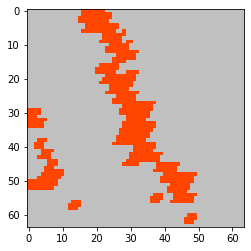

In [28]:
plt.imshow(inputs[20, :, :, -1], cmap=CMAP, norm=NORM) 

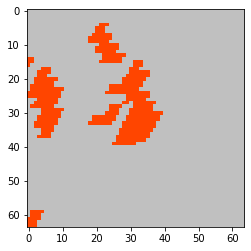

In [26]:
plt.imshow(labelss[20, :, :], cmap=CMAP, norm=NORM) 

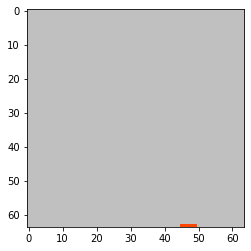

In [27]:
plt.imshow(preds[20, :, :], cmap=CMAP, norm=NORM) 